# Bibliotecas

In [2]:
import yfinance as yf
from matplotlib import pyplot as plt
import pandas as pd
import mplfinance as mplf
from os.path import exists
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyRegressor

# Obter Dados

In [3]:
if not exists('historico.csv'):
    hist = yf.download('ITSA4.SA', period='10y', interval='1d')
    hist.to_csv('historico.csv')
else:
    hist = pd.read_csv('historico.csv', index_col='Date', parse_dates=True)  
hist

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-06-28,4.74,4.85,4.71,4.79,2.78,40626625
2013-07-01,4.74,4.88,4.71,4.82,2.80,21682984
2013-07-02,4.76,4.80,4.50,4.59,2.66,37180692
2013-07-03,4.57,4.63,4.46,4.53,2.63,40771369
2013-07-04,4.61,4.65,4.56,4.58,2.66,26815484
...,...,...,...,...,...,...
2023-06-21,9.80,9.95,9.79,9.89,9.77,19003800
2023-06-22,9.80,9.86,9.71,9.77,9.66,16028300
2023-06-23,9.70,9.72,9.57,9.66,9.66,12688500


# Tratamento de Dados

### Ajuste de Preços

In [4]:
histAdj = hist.copy()
histAdj = histAdj.drop(columns=['Adj Close', 'Volume'])
adj = hist['Adj Close'] / hist['Close']
histAdj = histAdj.multiply(adj, axis=0)
histAdj

,Open,High,Low,Close
Date,,,,
2013-06-28,2.75,2.82,2.74,2.78
2013-07-01,2.75,2.83,2.74,2.80
2013-07-02,2.77,2.79,2.61,2.66
2013-07-03,2.65,2.69,2.59,2.63
2013-07-04,2.67,2.70,2.65,2.66
...,...,...,...,...
2023-06-21,9.69,9.83,9.68,9.77
2023-06-22,9.69,9.74,9.60,9.66
2023-06-23,9.70,9.72,9.57,9.66


### Gerando colunas com preços passados

In [5]:
for i in range(100):
    histAdj['Close'+str(i+1)] = histAdj['Close'].shift(i+1)
    histAdj['Open'+str(i+1)] = histAdj['Open'].shift(i+1)
    histAdj['High'+str(i+1)] = histAdj['High'].shift(i+1)
    histAdj['Low'+str(i+1)] = histAdj['Low'].shift(i+1)
histAdj = histAdj.dropna()
histAdj

,Open,High,Low,Close,Close1,Open1,High1,Low1,Close2,Open2,...,High98,Low98,Close99,Open99,High99,Low99,Close100,Open100,High100,Low100
Date,,,,,,,,,,,,,,,,,,,,,
2013-11-19,3.27,3.27,3.15,3.20,3.28,3.23,3.28,3.23,3.23,3.17,...,2.79,2.61,2.80,2.75,2.83,2.74,2.78,2.75,2.82,2.74
2013-11-21,3.16,3.20,3.14,3.16,3.20,3.27,3.27,3.15,3.28,3.23,...,2.69,2.59,2.66,2.77,2.79,2.61,2.80,2.75,2.83,2.74
2013-11-22,3.14,3.16,3.05,3.11,3.16,3.16,3.20,3.14,3.20,3.27,...,2.70,2.65,2.63,2.65,2.69,2.59,2.66,2.77,2.79,2.61
2013-11-25,3.12,3.13,3.01,3.06,3.11,3.14,3.16,3.05,3.16,3.16,...,2.65,2.54,2.66,2.67,2.70,2.65,2.63,2.65,2.69,2.59
2013-11-26,3.03,3.15,3.03,3.09,3.06,3.12,3.13,3.01,3.11,3.14,...,2.68,2.58,2.63,2.64,2.65,2.54,2.66,2.67,2.70,2.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-21,9.69,9.83,9.68,9.77,9.70,9.65,9.71,9.58,9.66,9.58,...,8.45,8.32,8.35,8.32,8.36,8.19,8.33,8.18,8.35,8.18
2023-06-22,9.69,9.74,9.60,9.66,9.77,9.69,9.83,9.68,9.70,9.65,...,8.41,8.19,8.39,8.37,8.45,8.32,8.35,8.32,8.36,8.19
2023-06-23,9.70,9.72,9.57,9.66,9.66,9.69,9.74,9.60,9.77,9.69,...,8.27,8.16,8.19,8.41,8.41,8.19,8.39,8.37,8.45,8.32


# Teste de Modelo de Regressão

### Separar dados de treino e teste

In [6]:
x = histAdj.drop(columns=['Open', 'Close', 'High', 'Low'])
y = histAdj[['Open', 'High', 'Low', 'Close']]
splitDays = 250
x_train, x_test, y_train, y_test = x.iloc[:-splitDays], x.iloc[-splitDays:], y.iloc[:-splitDays], y.iloc[-splitDays:]
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=splitDays)

### Lazy Regressor

In [7]:
from lazypredict.Supervised import LazyRegressor

lazyReg = LazyRegressor()
# lazyReg.fit(x_train, x_test, y_train, y_test)

### Criando um dos modelos encontrados

In [8]:
from sklearn.linear_model import OrthogonalMatchingPursuit
from math import sqrt

modelo = OrthogonalMatchingPursuit()
modelo.fit(x_train, y_train)
y_train_predict = modelo.predict(x_train)
y_test_predict = modelo.predict(x_test)
print('Treino R2:', r2_score(y_train, y_train_predict))
print('Teste R2:', r2_score(y_test, y_test_predict))
print('Treino RMSE:', sqrt(mean_squared_error(y_train, modelo.predict(x_train))))
print('Teste RMSE:', sqrt(mean_squared_error(y_test, modelo.predict(x_test))))


Treino R2: 0.9982366679125704
Teste R2: 0.9697106444261383
Treino RMSE: 0.09064077707239025
Teste RMSE: 0.10152781138643599


# Visualização

### Dados do Histórico

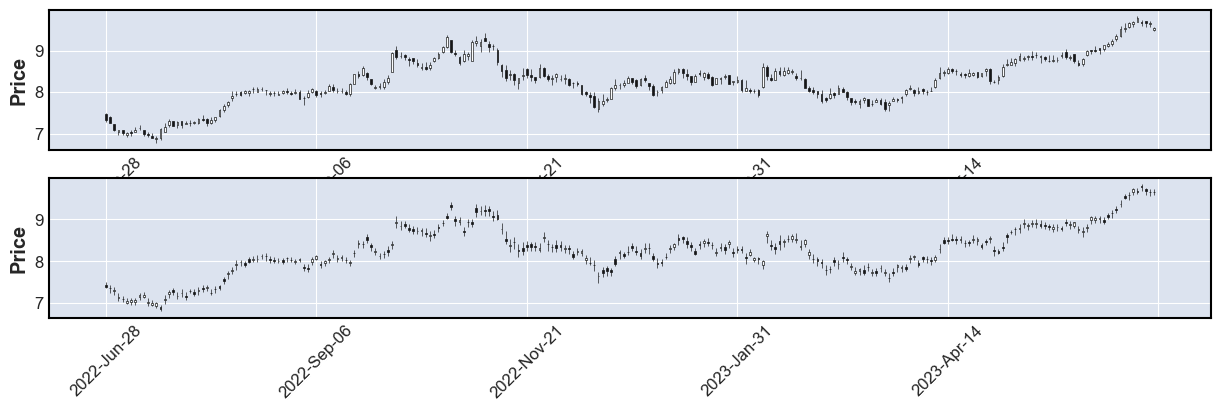

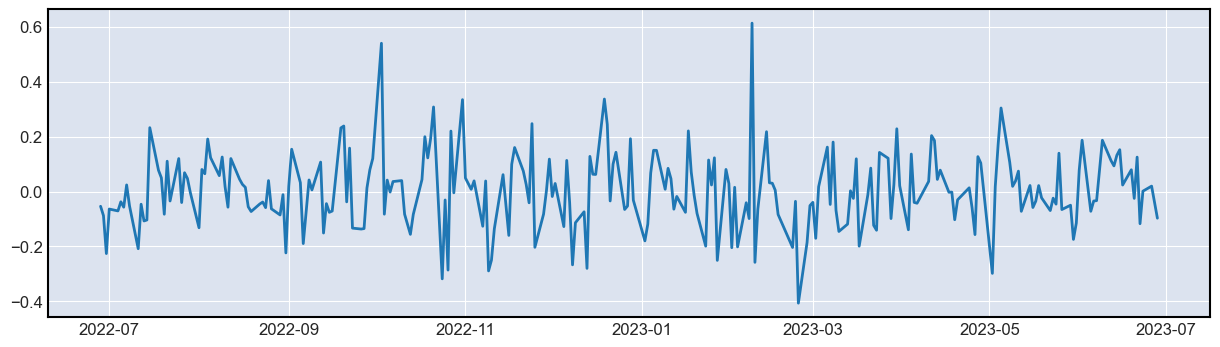

In [9]:
fig = mplf.figure(figsize=(15, 4))
mplf.plot(y_test, type='candle', ax=fig.add_subplot(2, 1, 1))
prediction = modelo.predict(x_test)
dfPrediction = pd.DataFrame(prediction, y_test.index, y_test.columns)
mplf.plot(dfPrediction, type='candle', ax=fig.add_subplot(2, 1, 2))
dif = y - dfPrediction
plt.figure(figsize=(15, 4))
plt.plot(dif['Close'])
plt.show()

# Prever ontem, hoje e amanhã

In [12]:
histAtual = yf.download('ITSA4.SA', period='103d', interval='1d')
adj = histAtual['Adj Close'] / histAtual['Close']
histAtual = histAtual.drop(columns=['Adj Close', 'Volume'])
histAtual = histAtual.multiply(adj, axis=0)
amanhaTimeStamp = histAtual.iloc[[-1]].index + pd.Timedelta(days=1)
amanhaDados = {
    'Open': 0,
    'High': 0,
    'Low': 0,
    'Close': 0
}
histAtual = pd.concat([histAtual, pd.DataFrame([amanhaDados], index=amanhaTimeStamp)])
for i in range(100):
    histAtual['Close'+str(i+1)] = histAtual['Close'].shift(i+1)
    histAtual['Open'+str(i+1)] = histAtual['Open'].shift(i+1)
    histAtual['High'+str(i+1)] = histAtual['High'].shift(i+1)
    histAtual['Low'+str(i+1)] = histAtual['Low'].shift(i+1)
histAtual = histAtual.dropna()
colunas = ['Open', 'High', 'Low', 'Close']
x = histAtual.drop(columns=colunas)
previsao = pd.DataFrame(modelo.predict(x), index=x.index, columns=colunas)
print('\nDados Baixados:\n', histAtual.iloc[-3:][colunas])
print('\nPrevisão:\n', previsao)

[*********************100%***********************]  1 of 1 completed

Dados Baixados:
             Open  High  Low  Close
Date                              
2023-06-26  9.65  9.72 9.57   9.66
2023-06-28  9.50  9.57 9.45   9.46
2023-06-29  0.00  0.00 0.00   0.00

Previsão:
             Open  High  Low  Close
Date                              
2023-06-26  9.66  9.72 9.54   9.64
2023-06-28  9.65  9.71 9.57   9.64
2023-06-29  9.51  9.59 9.43   9.54
